# **MAIN CODE**

In [1]:
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

x = sp.symbols('x')

# ==============================================================================
# NUMERIC FUNCTIONS
# ==============================================================================
def numeric(function: str, tol: float, max_iter: int, method: str = 'bisection',
            low: float = None, up: float = None,
            initial_guess: float = None, g_function: str = None):
    result = {
        'root': None,
        'iterations': pd.DataFrame(),
        'error': None,
        'converged_at': None
    }

    """
    Numerically solves for a root of a given mathematical function using various iterative methods.

    Parameters:
    -----------
    function : str
        A string representation of the target function f(x) whose root is to be found.
        Must be a valid SymPy-compatible expression (e.g., "x**2 - 4").

    tol : float
        Tolerance threshold for convergence. The algorithm stops when |f(x)| < tol or
        the change between successive approximations is less than tol (depending on method).

    max_iter : int
        Maximum number of iterations allowed before termination, regardless of convergence.

    method : str, optional (default: 'bisection')
        The root-finding algorithm to use. Supported methods:
        - 'bisection'       : Bisection method (requires interval [low, up])
        - 'regula_falsi'    : Regula Falsi (false position) method
        - 'secant'          : Secant method (requires two initial guesses: low, up)
        - 'fixed_point'     : Fixed-point iteration (requires g_function and initial_guess)
        - 'newton'          : Newton-Raphson method (requires initial_guess)
        - 'aitken'          : Aitken's delta-squared acceleration applied to fixed-point iteration
        - 'steffensen'      : Steffensen's method (accelerated fixed-point, requires g_function)

    low : float, optional
        Lower bound of the interval for bracketing methods (bisection, regula_falsi)
        or the first initial guess for the secant method.

    up : float, optional
        Upper bound of the interval for bracketing methods or the second initial guess
        for the secant method.

    initial_guess : float, optional
        Starting point for open methods (Newton, fixed-point, Aitken, Steffensen).

    g_function : str, optional
        String representation of the iteration function g(x) used in fixed-point-based methods,
        where the root of f(x) = 0 is reformulated as x = g(x). Required for:
        'fixed_point', 'aitken', and 'steffensen'.

    Returns:
    --------
    result : dict
        A dictionary containing the following keys:

        - 'root' : float or None
            The computed root approximation. None if an error occurred before computation.

        - 'iterations' : pandas.DataFrame
            A table logging iteration details (columns vary by method). Empty if error occurred early.

        - 'error' : str or None
            Error message if any validation or runtime error occurred; None if no error.

        - 'converged_at' : int or None
            The iteration number at which convergence was achieved (based on tolerance).
            None if the method did not converge within max_iter.

    Notes:
    ------
    - The global SymPy symbol `x` is used internally for parsing expressions.
    - All function evaluations are performed with floating-point arithmetic.
    - Complex results (e.g., from invalid g(x)) are treated as errors in fixed-point variants.
    - Bracketing methods (bisection, regula_falsi) require f(low) * f(up) < 0.
    - Newton’s method requires a non-zero derivative at each step.
    - Aitken and Steffensen methods accelerate fixed-point iteration and require a valid g(x).
    """

    try:
        f = sp.sympify(function)
    except Exception as e:
        result['error'] = f"Invalid function: {e}"
        return result

    method_key = method.lower()
    valid_methods = ['bisection', 'regula_falsi', 'secant', 'fixed_point', 'newton', 'aitken', 'steffensen']
    if method_key not in valid_methods:
        result['error'] = f"Method '{method}' is not recognized"
        return result

    # General validation
    if method_key in ['bisection', 'regula_falsi']:
        if low is None or up is None or low >= up:
            result['error'] = "This method requires low < up"
            return result

    if method_key == 'secant':
        if low is None or up is None:
            result['error'] = "Secant method requires two initial guesses (low, up)"
            return result

    # g(x)-based methods require g_function and initial_guess
    if method_key in ['fixed_point', 'aitken', 'steffensen']:
        if g_function is None:
            result['error'] = f"Method {method_key} requires g_function"
            return result
        if initial_guess is None:
            result['error'] = f"Method {method_key} requires initial_guess"
            return result
        try:
            g = sp.sympify(g_function)
        except Exception as e:
            result['error'] = f"Invalid g_function: {e}"
            return result

    if method_key == 'newton':
        if initial_guess is None:
            result['error'] = "Newton's method requires initial_guess"
            return result
        try:
            df_expr = sp.diff(f, x)
        except Exception as e:
            result['error'] = f"Failed to compute derivative: {e}"
            return result

    # Sign check for interval-based methods
    if method_key in ['bisection', 'regula_falsi']:
        try:
            f_low = float(f.subs(x, low).evalf())
            f_up = float(f.subs(x, up).evalf())
            if f_low * f_up > 0:
                result['error'] = f"No root in [{low}, {up}]: f(low)={f_low:.6f}, f(up)={f_up:.6f}"
                return result
        except Exception as e:
            result['error'] = f"Error evaluating bounds: {e}"
            return result

    iteration_data = []

    try:
        converged = False

        # ========== BISECTION ==========
        if method_key == 'bisection':
            a, b = float(low), float(up)
            for i in range(1, max_iter + 1):
                c = (a + b) / 2
                f_c = float(f.subs(x, c).evalf())
                iteration_data.append({'iterasi': i, 'a': a, 'b': b, 'c': c, 'f(c)': f_c})
                if abs(f_c) < tol:
                    result['root'] = c
                    result['converged_at'] = i
                    converged = True
                    break
                f_a = float(f.subs(x, a).evalf())
                if f_a * f_c < 0:
                    b = c
                else:
                    a = c
            if not converged:
                result['root'] = c

        # ========== REGULA FALSI ==========
        elif method_key == 'regula_falsi':
            a, b = float(low), float(up)
            for i in range(1, max_iter + 1):
                f_a = float(f.subs(x, a).evalf())
                f_b = float(f.subs(x, b).evalf())
                if abs(f_b - f_a) < 1e-15:
                    result['error'] = "f(b) - f(a) is too small"
                    return result
                c = (a * f_b - b * f_a) / (f_b - f_a)
                f_c = float(f.subs(x, c).evalf())
                iteration_data.append({'iterasi': i, 'a': a, 'b': b, 'c': c, 'f(c)': f_c})
                if abs(f_c) < tol:
                    result['root'] = c
                    result['converged_at'] = i
                    converged = True
                    break
                if f_a * f_c < 0:
                    b = c
                else:
                    a = c
            if not converged:
                result['root'] = c

        # ========== SECANT ==========
        elif method_key == 'secant':
            x0, x1 = float(low), float(up)
            f_x0 = float(f.subs(x, x0).evalf())
            f_x1 = float(f.subs(x, x1).evalf())
            for i in range(1, max_iter + 1):
                if abs(f_x1 - f_x0) < 1e-15:
                    result['error'] = "f(x1) - f(x0) is too small"
                    return result
                x2 = x1 - (f_x1 * (x1 - x0)) / (f_x1 - f_x0)
                f_x2 = float(f.subs(x, x2).evalf())
                iteration_data.append({'iterasi': i, 'x0': x0, 'x1': x1, 'x2': x2, 'f(x2)': f_x2})
                if abs(f_x2) < tol:
                    result['root'] = x2
                    result['converged_at'] = i
                    converged = True
                    break
                x0, x1 = x1, x2
                f_x0, f_x1 = f_x1, f_x2
            if not converged:
                result['root'] = x2

        # ========== FIXED-POINT ==========
        elif method_key == 'fixed_point':
            x_prev = float(initial_guess)
            for i in range(1, max_iter + 1):
                x_next_expr = g.subs(x, x_prev).evalf()
                x_next = complex(x_next_expr)
                if abs(x_next.imag) > 1e-10:
                    result['error'] = f"Complex result at iteration {i}"
                    return result
                x_next = x_next.real
                f_val = float(f.subs(x, x_prev).evalf())
                error = abs(x_next - x_prev)
                iteration_data.append({
                    'iterasi': i,
                    'x_n': x_prev,
                    'x_next': x_next,
                    'error': error,
                    'f(x_n)': f_val
                })
                if error < tol or abs(f_val) < tol:
                    result['root'] = x_next
                    result['converged_at'] = i
                    converged = True
                    break
                x_prev = x_next
            if not converged:
                result['root'] = x_prev

        # ========== NEWTON ==========
        elif method_key == 'newton':
            x_curr = float(initial_guess)
            for i in range(1, max_iter + 1):
                f_val = float(f.subs(x, x_curr).evalf())
                df_val = float(df_expr.subs(x, x_curr).evalf())
                if abs(df_val) < 1e-15:
                    result['error'] = f"Zero derivative at iteration {i}"
                    return result
                x_next = x_curr - f_val / df_val
                error = abs(x_next - x_curr)
                iteration_data.append({
                    'iterasi': i,
                    'x_n': x_curr,
                    'f(x_n)': f_val,
                    "f'(x_n)": df_val,
                    'error': error
                })
                if error < tol or abs(f_val) < tol:
                    result['root'] = x_next
                    result['converged_at'] = i
                    converged = True
                    break
                x_curr = x_next
            if not converged:
                result['root'] = x_curr

        # ========== AITKEN'S DELTA-SQUARED ==========
        elif method_key == 'aitken':
            x0 = float(initial_guess)
            for i in range(1, max_iter + 1):
                # Compute x1 = g(x0), x2 = g(x1)
                x1_expr = g.subs(x, x0).evalf()
                x1 = complex(x1_expr).real
                x2_expr = g.subs(x, x1).evalf()
                x2 = complex(x2_expr).real

                denom = x2 - 2*x1 + x0
                if abs(denom) < 1e-15:
                    # If denominator is zero, use x0 as fallback
                    x_hat = x0
                    f_val = float(f.subs(x, x_hat).evalf())
                    error = 0.0  # or NaN
                    iteration_data.append({
                        'iterasi': i,
                        'x0': x0,
                        'x1': x1,
                        'x2': x2,
                        'x_hat': x_hat,
                        'error': error,
                        'f(x_hat)': f_val
                    })
                    # Continue to next iteration
                    # Record error but do not stop the process
                    if result['error'] is None:
                        result['error'] = f"Aitken denominator zero at iteration {i} — fallback to x0 used"
                    # Still update x0 for the next iteration
                    x0 = x_hat
                else:
                    # Aitken's formula: x_hat = x0 - (x1 - x0)^2 / (x2 - 2*x1 + x0)
                    x_hat = x0 - (x1 - x0)**2 / denom
                    f_val = float(f.subs(x, x_hat).evalf())
                    error = abs(x_hat - x0)

                    iteration_data.append({
                        'iterasi': i,
                        'x0': x0,
                        'x1': x1,
                        'x2': x2,
                        'x_hat': x_hat,
                        'error': error,
                        'f(x_hat)': f_val
                    })

                    if abs(f_val) < tol or error < tol:
                        result['root'] = x_hat
                        result['converged_at'] = i
                        converged = True
                        break

                    x0 = x_hat  # Use accelerated result as next starting point

            if not converged:
                result['root'] = x_hat

        # ========== STEFFENSEN'S METHOD ==========
        elif method_key == 'steffensen':
            x_curr = float(initial_guess)
            for i in range(1, max_iter + 1):
                gx = float(g.subs(x, x_curr).evalf())
                ggx = float(g.subs(x, gx).evalf())
                denom = ggx - 2*gx + x_curr
                if abs(denom) < 1e-15:
                    result['error'] = f"Steffensen denominator zero at iteration {i}"
                    return result
                x_next = x_curr - (gx - x_curr)**2 / denom
                f_val = float(f.subs(x, x_next).evalf())
                error = abs(x_next - x_curr)

                iteration_data.append({
                    'iterasi': i,
                    'x': x_curr,
                    'g(x)': gx,
                    'g(g(x))': ggx,
                    'x_next': x_next,
                    'error': error,
                    'f(x_next)': f_val
                })

                if abs(f_val) < tol or error < tol:
                    result['root'] = x_next
                    result['converged_at'] = i
                    converged = True
                    break

                x_curr = x_next  # update for next iteration

            if not converged:
                result['root'] = x_next

        result['iterations'] = pd.DataFrame(iteration_data)
        return result

    except Exception as e:
        result['error'] = f"Internal error: {e}"
        return result

def find_all_roots(function_str: str, x_range: tuple = (-3, 3), steps: int = 1000, tol: float = 1e-12):
    """
    Find all real roots of the function within the interval [x_min, x_max]
    by scanning for sign changes and using nsolve.
    """
    x = sp.symbols('x')
    f = sp.sympify(function_str)
    f_lambdified = sp.lambdify(x, f, 'numpy')

    x_min, x_max = x_range
    xs = np.linspace(x_min, x_max, steps)
    fs = f_lambdified(xs)

    # Avoid NaN/inf
    valid = np.isfinite(fs)
    xs = xs[valid]
    fs = fs[valid]

    roots = []
    for i in range(len(xs) - 1):
        if fs[i] == 0:
            root = float(xs[i])
            roots.append(root)
        elif fs[i] * fs[i+1] < 0:  # Sign change → root exists
            try:
                guess = (xs[i] + xs[i+1]) / 2
                root = float(sp.nsolve(f, guess, tol=tol, maxsteps=100))
                # Avoid duplicates (very close roots)
                if not any(abs(root - r) < 1e-8 for r in roots):
                    roots.append(root)
            except Exception:
                continue  # nsolve failed, skip

    roots.sort()
    return roots

# **TESTING**

# **POLYONOMIAL**

=== NUMERICAL METHODS COMPARISON ===
Function: f(x) = x**7-2*x**6+4*x**5-1
g(x) for fixed-point: real_root(2*x**6-4*x**5+1,7)
Tolerance: 1e-10
Root search interval: [0, 1]

FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD

 1. Method Bisection
   Root: 0.800631154474104
   Status: ✓ Converged at iteration 35

 2. Method Regula Falsi
   Root: 0.800631154464212
   Status: ✓ Converged at iteration 28

 3. Method Secant
   Root: 0.800631154472581
   Status: ✓ Converged at iteration 14

 4. Method Fixed-Point
   Root: 0.800631154501102
   Status: ✓ Converged at iteration 17

 5. Method Aitken
   Root: 0.800631154465654
   Status: ✓ Converged at iteration 18

 6. Method Steffensen
   Root: 0.800631154472582
   Status: ✓ Converged at iteration 4

 7. Method Newton
   Root: 0.800631154472582
   Status: ✓ Converged at iteration 9

Found 1 real roots globally:
  Root 1: 0.800631154472582

Roots in interval [0, 1]: 1 found
  → Root 1: 0.800631154472582

COMPARISON SUMMARY
      Method   Numeric Roo

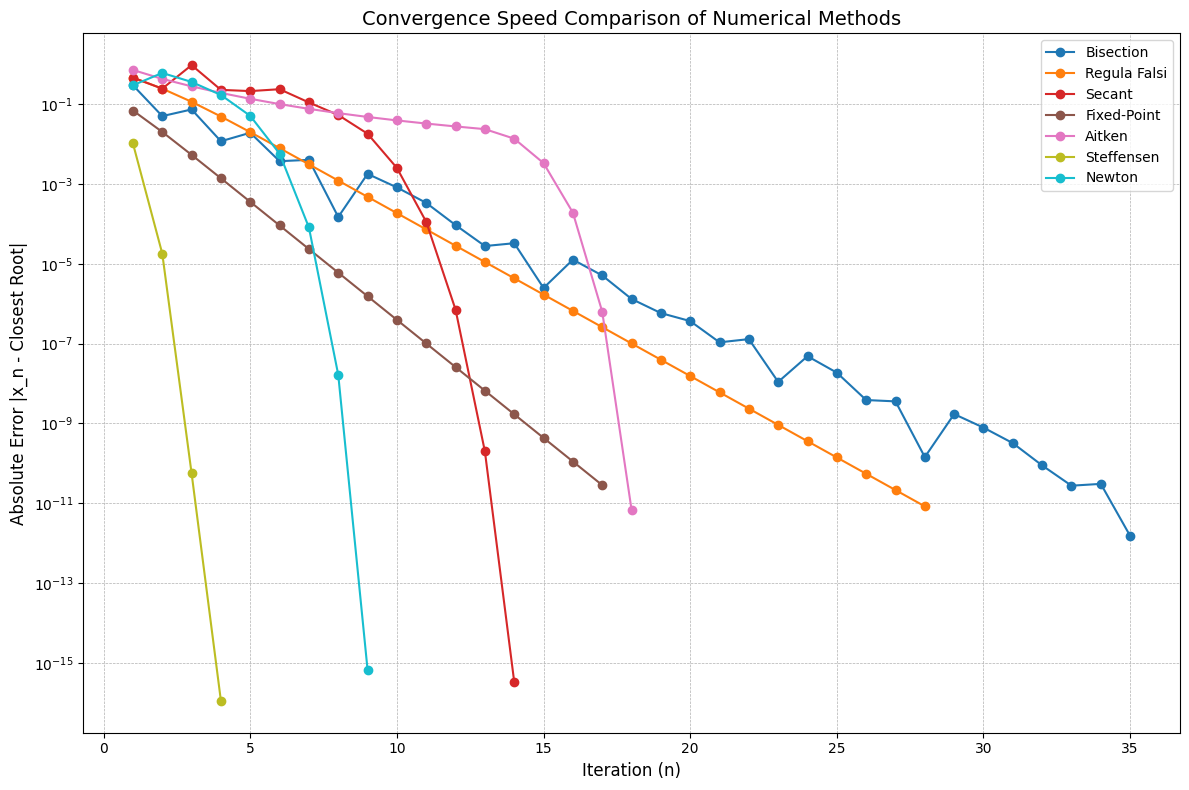

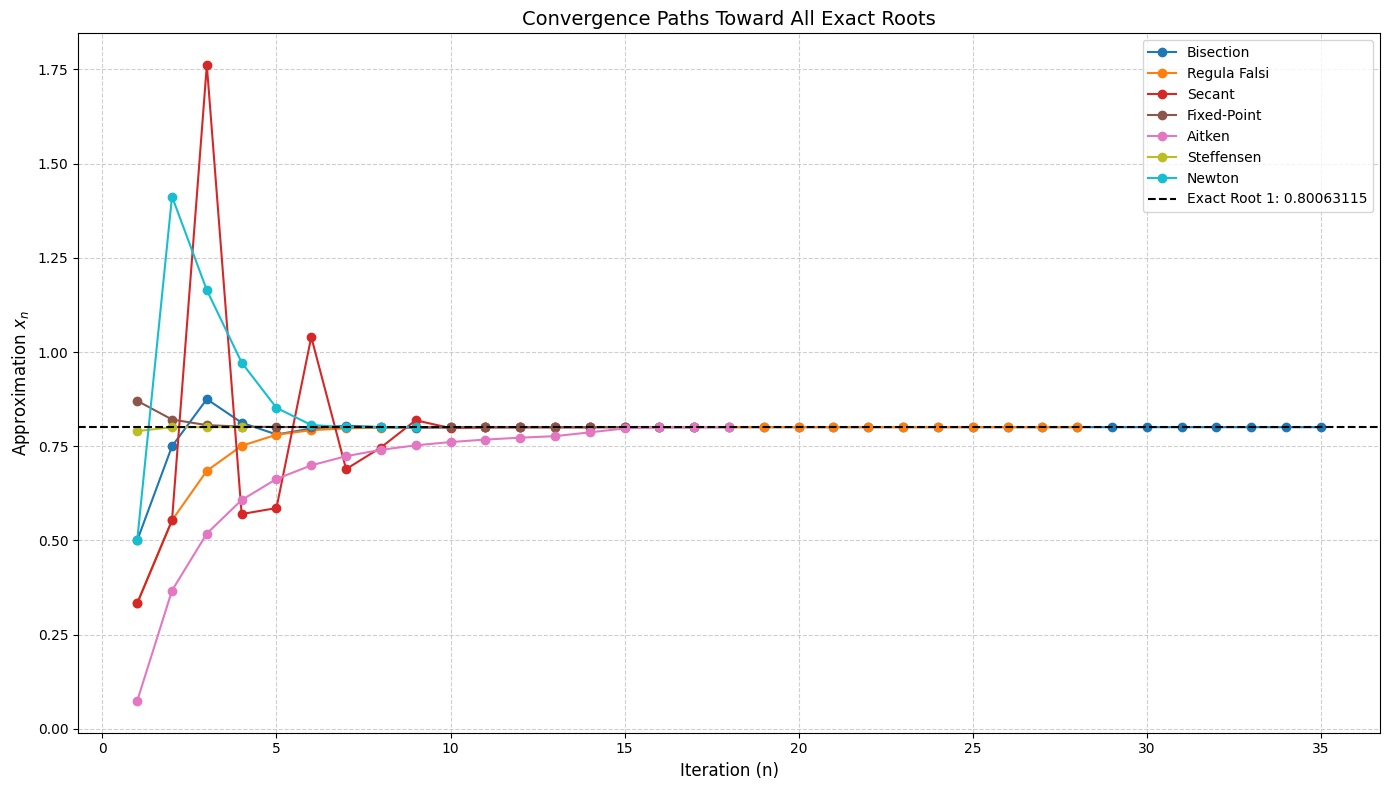

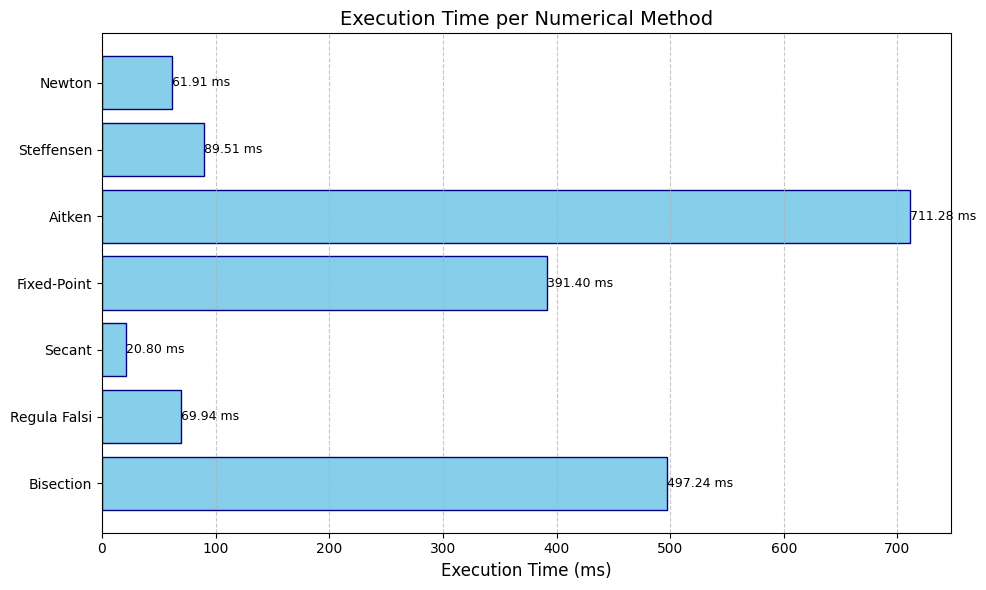


📁 All results (CSV + graphs) saved in folder: 'numerical_results'


In [2]:
def main():
    function = "x**7-2*x**6+4*x**5-1"
    g_func = "real_root(2*x**6-4*x**5+1,7)"
    g_func_1 = "real_root((-x**7+2*x**6+1)/4,5)"
    max_iter = 100
    tol = 1e-10
    low, up = 0, 1
    lower_bound, upper_bound = 0, up

    print("=== NUMERICAL METHODS COMPARISON ===")
    print(f"Function: f(x) = {function}")
    print(f"g(x) for fixed-point: {g_func}")
    print(f"Tolerance: {tol}")
    print(f"Root search interval: [{lower_bound}, {upper_bound}]")
    print()

    import time

    # Run all methods with timing
    results = {}
    exec_times = {}

    methods_config = {
        'Bisection': {'method': 'bisection', 'low': low, 'up': up},
        'Regula Falsi': {'method': 'regula_falsi', 'low': low, 'up': up},
        'Secant': {'method': 'secant', 'low': low, 'up': up},
        'Fixed-Point': {'method': 'fixed_point', 'initial_guess': up, 'g_function': g_func_1},
        'Aitken': {'method': 'aitken', 'initial_guess': up, 'g_function': g_func},
        'Steffensen': {'method': 'steffensen', 'initial_guess': up, 'g_function': g_func_1},
        'Newton': {'method': 'newton', 'initial_guess': (low + up) / 2}
    }

    for name, config in methods_config.items():
        start = time.perf_counter()
        res = numeric(function, tol=tol, max_iter=max_iter, **config)
        end = time.perf_counter()
        results[name] = res
        exec_times[name] = (end - start) * 1000
    # Display final results
    print("="*80)
    print("FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD")
    print("="*80)
    for index, (name, res) in enumerate(results.items(), 1):
        print(f"\n {index}. Method {name}")
        if res['error']:
            print(f"   Error: {res['error']}")
        elif res['root'] is not None:
            iterations = res['converged_at'] if res['converged_at'] is not None else max_iter
            status = "✓ Converged" if res['converged_at'] is not None else "⚠ Max iterations"
            print(f"   Root: {res['root']:.15f}")
            print(f"   Status: {status} at iteration {iterations}")
        else:
            print("   Failed")

    # ==============================================================================
    # EXACT SOLUTIONS: FIND ALL ROOTS IN [lower_bound, upper_bound]
    # ==============================================================================
    try:
        all_exact_roots = find_all_roots(function, x_range=(-3, 3), steps=2000)
        print(f"\nFound {len(all_exact_roots)} real roots globally:")
        for i, r in enumerate(all_exact_roots, 1):
            print(f"  Root {i}: {r:.15f}")

        exact_roots_in_interval = [r for r in all_exact_roots if lower_bound <= r <= upper_bound]
        print(f"\nRoots in interval [{lower_bound}, {upper_bound}]: {len(exact_roots_in_interval)} found")
        for i, r in enumerate(exact_roots_in_interval, 1):
            print(f"  → Root {i}: {r:.15f}")

    except Exception as e:
        print(f"\nFailed to compute exact solutions: {e}")
        exact_roots_in_interval = []

    # ==============================================================================
    # HELPER: FIND CLOSEST EXACT ROOT
    # ==============================================================================
    def find_closest_root(numeric_root, exact_list):
        if not exact_list:
            return None, None
        closest = min(exact_list, key=lambda r: abs(r - numeric_root))
        return closest, abs(numeric_root - closest)

    # ==============================================================================
    # SUMMARY TABLE
    # ==============================================================================
    print("\n" + "="*130)
    print("COMPARISON SUMMARY")
    print("="*130)
    summary_data = []
    for name, res in results.items():
        if res['error'] or res['root'] is None:
            summary_data.append({
                'Method': name,
                'Numeric Root': 'Error',
                'Closest Root': '—',
                'Iterations': '—',
                'Difference': '—',
                'Status': '—'
            })
        else:
            numeric_root = res['root']
            iterations = res['converged_at'] if res['converged_at'] is not None else f"{max_iter} (max)"
            closest_root, difference = find_closest_root(numeric_root, exact_roots_in_interval)

            status = "Valid" if lower_bound <= numeric_root <= upper_bound else "Invalid"

            summary_data.append({
                'Method': name,
                'Numeric Root': f"{numeric_root:.12f}",
                'Closest Root': f"{closest_root:.12f}" if closest_root is not None else "—",
                'Iterations': iterations,
                'Difference': f"{difference:.15f}" if difference is not None else "—",
                'Status': status
            })

    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))

    # ==============================================================================
    # SAVE ITERATION DATA TO CSV
    # ==============================================================================
    import os
    output_dir = "numerical_results"
    os.makedirs(output_dir, exist_ok=True)

    for name, res in results.items():
        if not res['error'] and not res['iterations'].empty:
            safe_name = "".join(c if c.isalnum() else "_" for c in name)
            filename = os.path.join(output_dir, f"iterations_{safe_name}_POLYNOMIAL.csv")
            res['iterations'].to_csv(filename, index=False, float_format="%.12f")

    summary_file = os.path.join(output_dir, "comparison_summary_POLYNOMIAL.csv")
    df_summary.to_csv(summary_file, index=False)

    # ==============================================================================
    # DISPLAY COMPLETE ITERATION DATA FOR EACH METHOD
    # ==============================================================================
    print("\n" + "="*100)
    print("COMPLETE ITERATION DATA FOR EACH METHOD")
    print("="*100)
    for name, res in results.items():
        print(f"\nITERATIONS FOR METHOD: {name}")
        print("-" * 60)
        if res['error']:
            print(f"No iteration data: {res['error']}")
        elif res['iterations'].empty:
            print("No iteration data (empty DataFrame)")
        else:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(res['iterations'].to_string(index=False, float_format="%.10f"))
        print()

    # ==============================================================================
    # EARLY EXIT IF NO EXACT ROOTS IN INTERVAL
    # ==============================================================================
    if not exact_roots_in_interval:
        print(f"\n⚠️  No exact roots in interval [{lower_bound}, {upper_bound}] → Skipping graphs.")
        print(f"📁 All results (CSV) saved in folder: '{output_dir}'")
        return

    # ==============================================================================
    # GRAPH 1: ABSOLUTE ERROR (LOG SCALE) — CONVERGENCE SPEED
    # ==============================================================================
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            approximations = df['x_n'].values
            if res['converged_at'] is None:
                approximations = np.append(approximations, res['root'])
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        errors = []
        for x in approximations:
            _, diff = find_closest_root(x, exact_roots_in_interval)
            errors.append(diff if diff is not None else float('nan'))
        errors = np.array(errors)
        iterations = np.arange(1, len(errors) + 1)

        valid = np.isfinite(errors)
        if np.any(valid):
            plt.plot(iterations[valid], errors[valid], marker='o', label=name, color=colors[idx])

    plt.yscale('log')
    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Absolute Error |x_n - Closest Root|', fontsize=12)
    plt.title('Convergence Speed Comparison of Numerical Methods', fontsize=14)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_error_POLYNOMIAL.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 2: APPROXIMATION PATH vs ITERATION — WITH ALL EXACT ROOTS
    # ==============================================================================
    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            x_vals = df['x_n'].values.tolist()
            if res['converged_at'] is None:
                x_vals.append(res['root'])
            approximations = np.array(x_vals)
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        iterations = np.arange(1, len(approximations) + 1)
        plt.plot(iterations, approximations, marker='o', label=name, color=colors[idx])

    for i, root in enumerate(exact_roots_in_interval, 1):
        plt.axhline(y=root, color='black', linestyle='--', linewidth=1.5,
                    label=f'Exact Root {i}: {root:.8f}')

    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Approximation $x_n$', fontsize=12)
    plt.title('Convergence Paths Toward All Exact Roots', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_path_POLYNOMIAL.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 3: EXECUTION TIME COMPARISON (HORIZONTAL BAR CHART)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    methods = list(exec_times.keys())
    times = [exec_times[m] for m in methods]

    # Horizontal bar: use `barh` instead of `bar`
    bars = plt.barh(methods, times, color='skyblue', edgecolor='navy')
    plt.xlabel('Execution Time (ms)', fontsize=12)
    plt.title('Execution Time per Numerical Method', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # Add value labels on bars
    for bar, t in zip(bars, times):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{t:.2f} ms', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "execution_time_POLYNOMIAL.png"), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📁 All results (CSV + graphs) saved in folder: '{output_dir}'")


if __name__ == "__main__":
    main()

# **TRIGONOMETRIC**

=== NUMERICAL METHODS COMPARISON ===
Function: f(x) = sin(x) - (cos(2*x)**3)
g(x) for fixed-point: asin(cos(2*x)**3)
Tolerance: 1e-10
Root search interval: [0, 3]

FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD

 1. Method Bisection
   Root: 2.758392986841500
   Status: ✓ Converged at iteration 29

 2. Method Regula Falsi
   Root: 2.758392986843663
   Status: ✓ Converged at iteration 5

 3. Method Secant
   Root: 2.758392986843174
   Status: ✓ Converged at iteration 5

 4. Method Fixed-Point
   Root: 0.383199666731017
   Status: ✓ Converged at iteration 28

 5. Method Aitken
   Root: 0.383199666746129
   Status: ✓ Converged at iteration 8

 6. Method Steffensen
   Root: 0.383199666746129
   Status: ✓ Converged at iteration 4

 7. Method Newton
   Root: 2.758392986843665
   Status: ✓ Converged at iteration 4

Found 2 real roots globally:
  Root 1: 0.383199666746128
  Root 2: 2.758392986843665

Roots in interval [0, 3]: 2 found
  → Root 1: 0.383199666746128
  → Root 2: 2.758392986843665


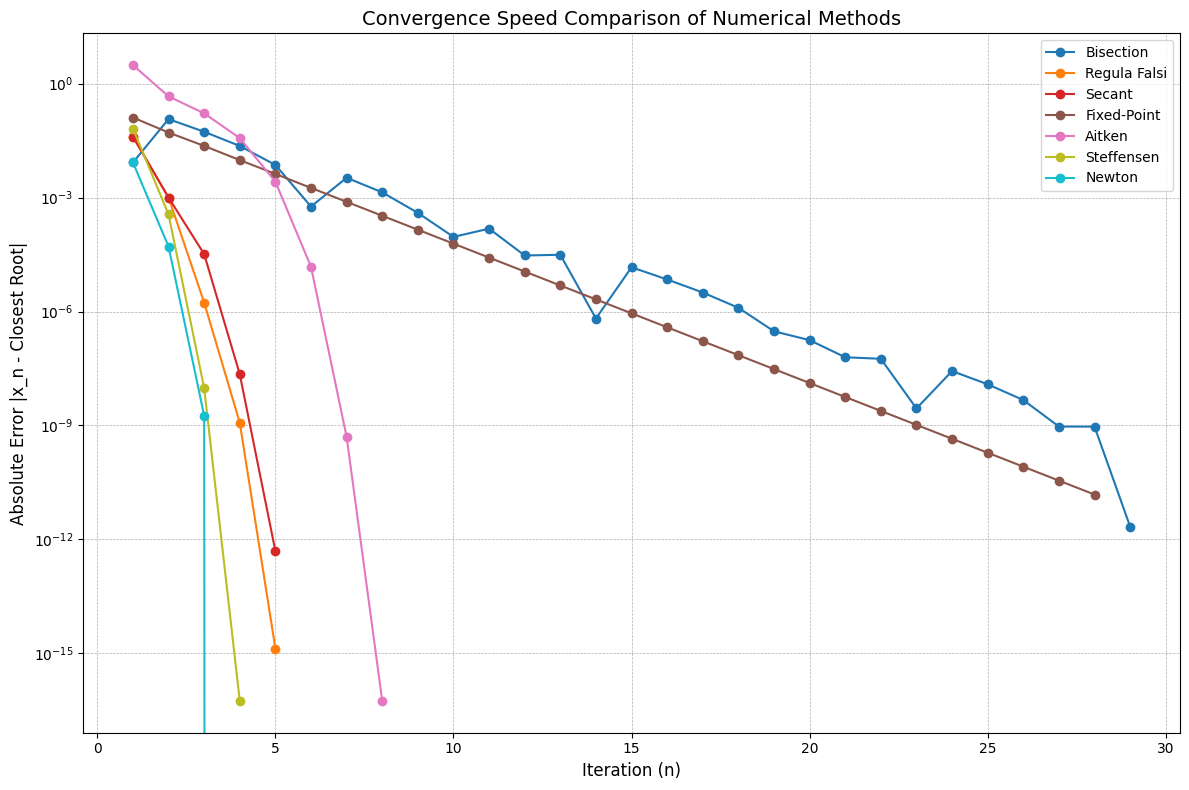

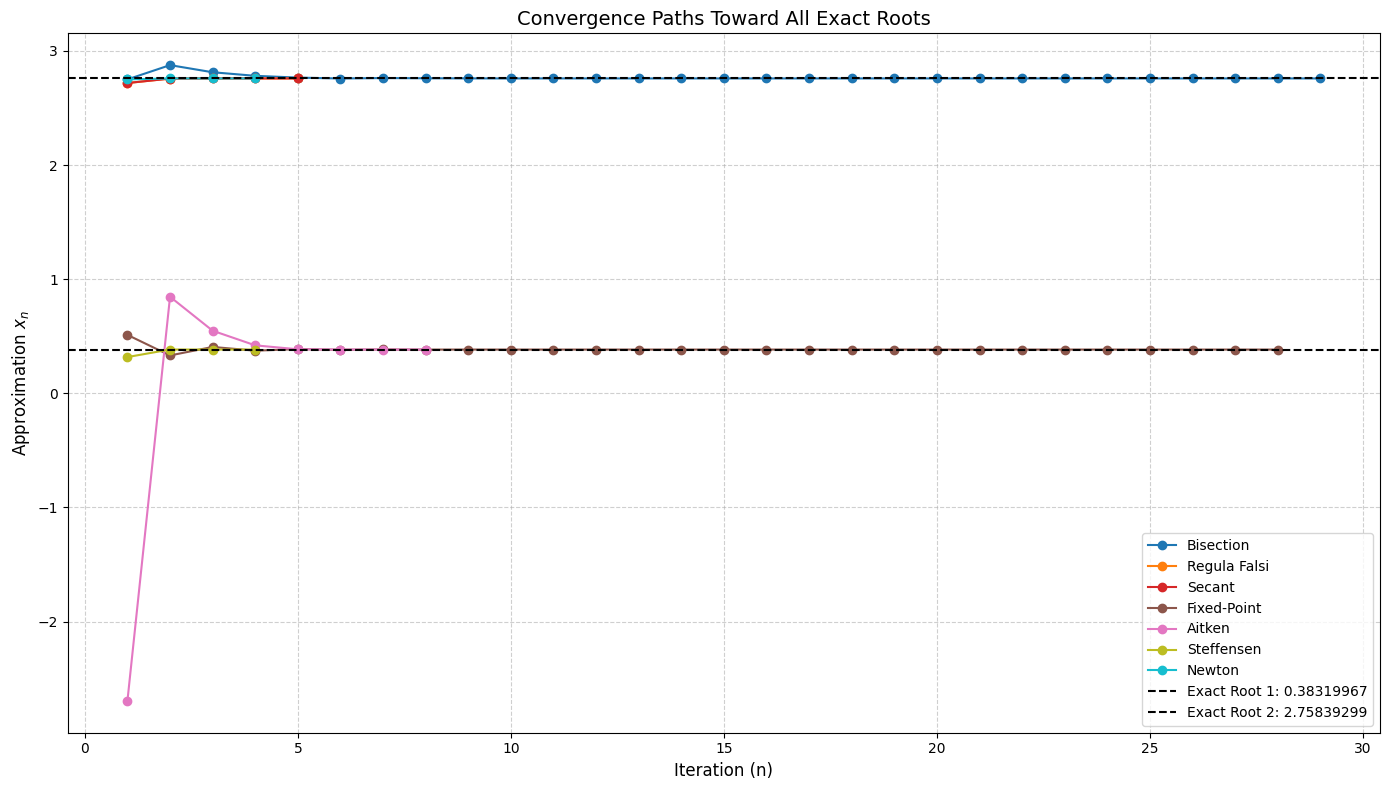

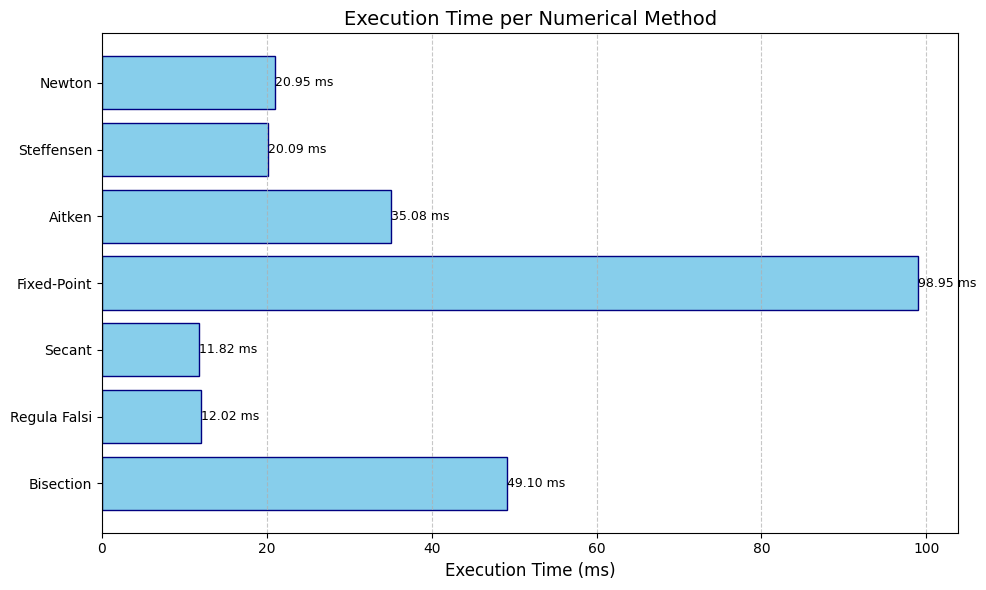


📁 All results (CSV + graphs) saved in folder: 'numerical_results'


In [3]:
def main():
    function = "sin(x) - (cos(2*x)**3)"
    g_func = "asin(cos(2*x)**3)"
    g_func_1 = "acos(real_root(sin(x), 3)) / 2"
    max_iter = 100
    tol = 1e-10
    low, up = 2.5, 3
    lower_bound, upper_bound = 0, up

    print("=== NUMERICAL METHODS COMPARISON ===")
    print(f"Function: f(x) = {function}")
    print(f"g(x) for fixed-point: {g_func}")
    print(f"Tolerance: {tol}")
    print(f"Root search interval: [{lower_bound}, {upper_bound}]")
    print()

    import time

    # Run all methods with timing
    results = {}
    exec_times = {}

    methods_config = {
        'Bisection': {'method': 'bisection', 'low': low, 'up': up},
        'Regula Falsi': {'method': 'regula_falsi', 'low': low, 'up': up},
        'Secant': {'method': 'secant', 'low': low, 'up': up},
        'Fixed-Point': {'method': 'fixed_point', 'initial_guess': up, 'g_function': g_func_1},
        'Aitken': {'method': 'aitken', 'initial_guess': up, 'g_function': g_func},
        'Steffensen': {'method': 'steffensen', 'initial_guess': up, 'g_function': g_func_1},
        'Newton': {'method': 'newton', 'initial_guess': (low + up) / 2}
    }

    for name, config in methods_config.items():
        start = time.perf_counter()
        res = numeric(function, tol=tol, max_iter=max_iter, **config)
        end = time.perf_counter()
        results[name] = res
        exec_times[name] = (end - start) * 1000

    # Display final results
    print("="*80)
    print("FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD")
    print("="*80)
    for index, (name, res) in enumerate(results.items(), 1):
        print(f"\n {index}. Method {name}")
        if res['error']:
            print(f"   Error: {res['error']}")
        elif res['root'] is not None:
            iterations = res['converged_at'] if res['converged_at'] is not None else max_iter
            status = "✓ Converged" if res['converged_at'] is not None else "⚠ Max iterations"
            print(f"   Root: {res['root']:.15f}")
            print(f"   Status: {status} at iteration {iterations}")
        else:
            print("   Failed")

    # ==============================================================================
    # EXACT SOLUTIONS: FIND ALL ROOTS IN [lower_bound, upper_bound]
    # ==============================================================================
    try:
        all_exact_roots = find_all_roots(function, x_range=(-3, 3), steps=2000)
        print(f"\nFound {len(all_exact_roots)} real roots globally:")
        for i, r in enumerate(all_exact_roots, 1):
            print(f"  Root {i}: {r:.15f}")

        exact_roots_in_interval = [r for r in all_exact_roots if lower_bound <= r <= upper_bound]
        print(f"\nRoots in interval [{lower_bound}, {upper_bound}]: {len(exact_roots_in_interval)} found")
        for i, r in enumerate(exact_roots_in_interval, 1):
            print(f"  → Root {i}: {r:.15f}")

    except Exception as e:
        print(f"\nFailed to compute exact solutions: {e}")
        exact_roots_in_interval = []

    # ==============================================================================
    # HELPER: FIND CLOSEST EXACT ROOT
    # ==============================================================================
    def find_closest_root(numeric_root, exact_list):
        if not exact_list:
            return None, None
        closest = min(exact_list, key=lambda r: abs(r - numeric_root))
        return closest, abs(numeric_root - closest)

    # ==============================================================================
    # SUMMARY TABLE
    # ==============================================================================
    print("\n" + "="*130)
    print("COMPARISON SUMMARY")
    print("="*130)
    summary_data = []
    for name, res in results.items():
        if res['error'] or res['root'] is None:
            summary_data.append({
                'Method': name,
                'Numeric Root': 'Error',
                'Closest Root': '—',
                'Iterations': '—',
                'Difference': '—',
                'Status': '—'
            })
        else:
            numeric_root = res['root']
            iterations = res['converged_at'] if res['converged_at'] is not None else f"{max_iter} (max)"
            closest_root, difference = find_closest_root(numeric_root, exact_roots_in_interval)

            status = "Valid" if lower_bound <= numeric_root <= upper_bound else "Invalid"

            summary_data.append({
                'Method': name,
                'Numeric Root': f"{numeric_root:.12f}",
                'Closest Root': f"{closest_root:.12f}" if closest_root is not None else "—",
                'Iterations': iterations,
                'Difference': f"{difference:.15f}" if difference is not None else "—",
                'Status': status
            })

    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))

    # ==============================================================================
    # SAVE ITERATION DATA TO CSV
    # ==============================================================================
    import os
    output_dir = "numerical_results"
    os.makedirs(output_dir, exist_ok=True)

    for name, res in results.items():
        if not res['error'] and not res['iterations'].empty:
            safe_name = "".join(c if c.isalnum() else "_" for c in name)
            filename = os.path.join(output_dir, f"iterations_{safe_name}_TRIGONOMETRIC.csv")
            res['iterations'].to_csv(filename, index=False, float_format="%.12f")

    summary_file = os.path.join(output_dir, "comparison_summary_TRIGONOMETRIC.csv")
    df_summary.to_csv(summary_file, index=False)

    # ==============================================================================
    # DISPLAY COMPLETE ITERATION DATA FOR EACH METHOD
    # ==============================================================================
    print("\n" + "="*100)
    print("COMPLETE ITERATION DATA FOR EACH METHOD")
    print("="*100)
    for name, res in results.items():
        print(f"\nITERATIONS FOR METHOD: {name}")
        print("-" * 60)
        if res['error']:
            print(f"No iteration data: {res['error']}")
        elif res['iterations'].empty:
            print("No iteration data (empty DataFrame)")
        else:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(res['iterations'].to_string(index=False, float_format="%.10f"))
        print()

    # ==============================================================================
    # EARLY EXIT IF NO EXACT ROOTS IN INTERVAL
    # ==============================================================================
    if not exact_roots_in_interval:
        print(f"\n⚠️  No exact roots in interval [{lower_bound}, {upper_bound}] → Skipping graphs.")
        print(f"📁 All results (CSV) saved in folder: '{output_dir}'")
        return

    # ==============================================================================
    # GRAPH 1: ABSOLUTE ERROR (LOG SCALE) — CONVERGENCE SPEED
    # ==============================================================================
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            approximations = df['x_n'].values
            if res['converged_at'] is None:
                approximations = np.append(approximations, res['root'])
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        errors = []
        for x in approximations:
            _, diff = find_closest_root(x, exact_roots_in_interval)
            errors.append(diff if diff is not None else float('nan'))
        errors = np.array(errors)
        iterations = np.arange(1, len(errors) + 1)

        valid = np.isfinite(errors)
        if np.any(valid):
            plt.plot(iterations[valid], errors[valid], marker='o', label=name, color=colors[idx])

    plt.yscale('log')
    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Absolute Error |x_n - Closest Root|', fontsize=12)
    plt.title('Convergence Speed Comparison of Numerical Methods', fontsize=14)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_error_TRIGONOMETRIC.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 2: APPROXIMATION PATH vs ITERATION — WITH ALL EXACT ROOTS
    # ==============================================================================
    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            x_vals = df['x_n'].values.tolist()
            if res['converged_at'] is None:
                x_vals.append(res['root'])
            approximations = np.array(x_vals)
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        iterations = np.arange(1, len(approximations) + 1)
        plt.plot(iterations, approximations, marker='o', label=name, color=colors[idx])

    for i, root in enumerate(exact_roots_in_interval, 1):
        plt.axhline(y=root, color='black', linestyle='--', linewidth=1.5,
                    label=f'Exact Root {i}: {root:.8f}')

    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Approximation $x_n$', fontsize=12)
    plt.title('Convergence Paths Toward All Exact Roots', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_path_TRIGONOMETRIC.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 3: EXECUTION TIME COMPARISON (HORIZONTAL BAR CHART)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    methods = list(exec_times.keys())
    times = [exec_times[m] for m in methods]

    # Horizontal bar: use `barh` instead of `bar`
    bars = plt.barh(methods, times, color='skyblue', edgecolor='navy')
    plt.xlabel('Execution Time (ms)', fontsize=12)
    plt.title('Execution Time per Numerical Method', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # Add value labels on bars
    for bar, t in zip(bars, times):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{t:.2f} ms', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "execution_time_TRIGONOMETRIC.png"), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📁 All results (CSV + graphs) saved in folder: '{output_dir}'")


if __name__ == "__main__":
    main()

# **EXPONENT**

=== NUMERICAL METHODS COMPARISON ===
Function: f(x) = exp(-x) - exp(-2*x) - exp(-3*x)
g(x) for fixed-point: -ln(exp(-2*x) + exp(-3*x))
Tolerance: 1e-10
Root search interval: [-2, 2]

FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD

 1. Method Bisection
   Root: 0.481211825041100
   Status: ✓ Converged at iteration 32

 2. Method Regula Falsi
   Root: 0.481211825176191
   Status: ✓ Converged at iteration 43

 3. Method Secant
   Root: 0.481211825059775
   Status: ✓ Converged at iteration 13

 4. Method Fixed-Point
   Root: 56.750942777355569
   Status: ✓ Converged at iteration 10

 5. Method Aitken
   Root: 0.481211825059603
   Status: ✓ Converged at iteration 4

 6. Method Steffensen
   Root: 0.481211825059603
   Status: ✓ Converged at iteration 4

 7. Method Newton
   Root: 0.481211825059603
   Status: ✓ Converged at iteration 4

Found 1 real roots globally:
  Root 1: 0.481211825059603

Roots in interval [-2, 2]: 1 found
  → Root 1: 0.481211825059603

COMPARISON SUMMARY
      Method   

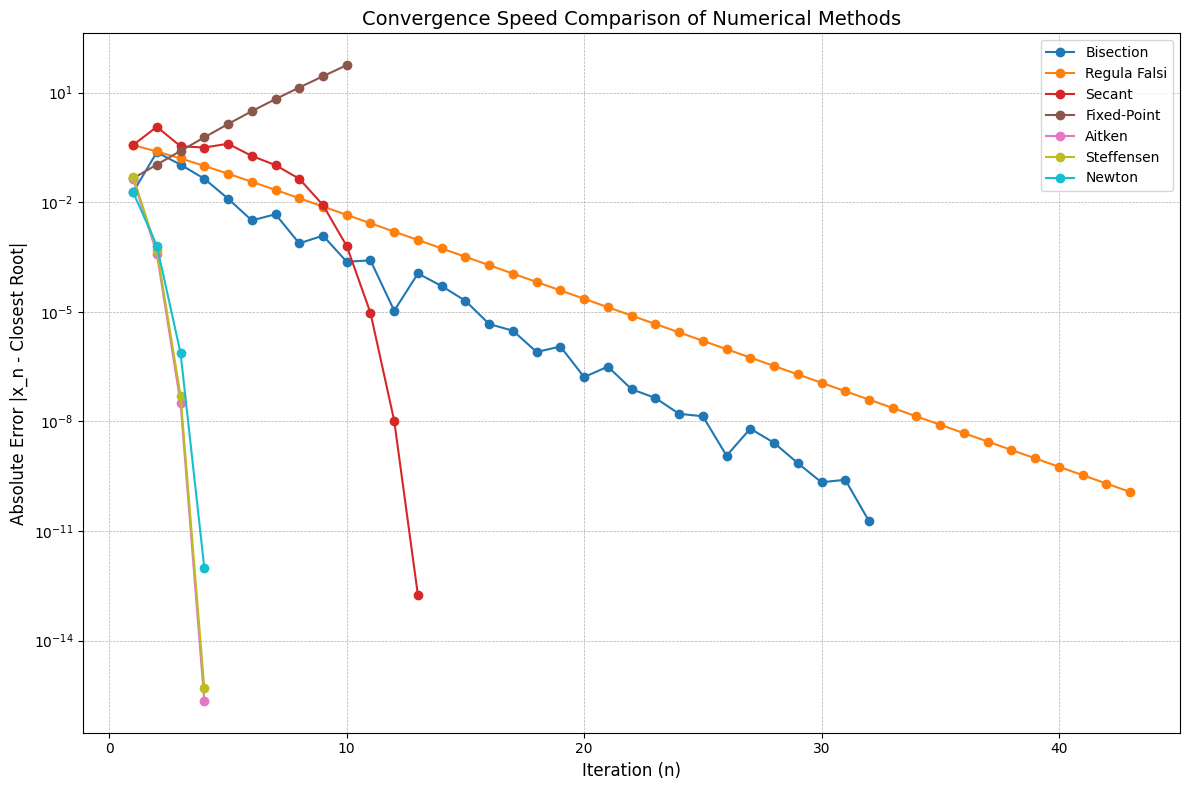

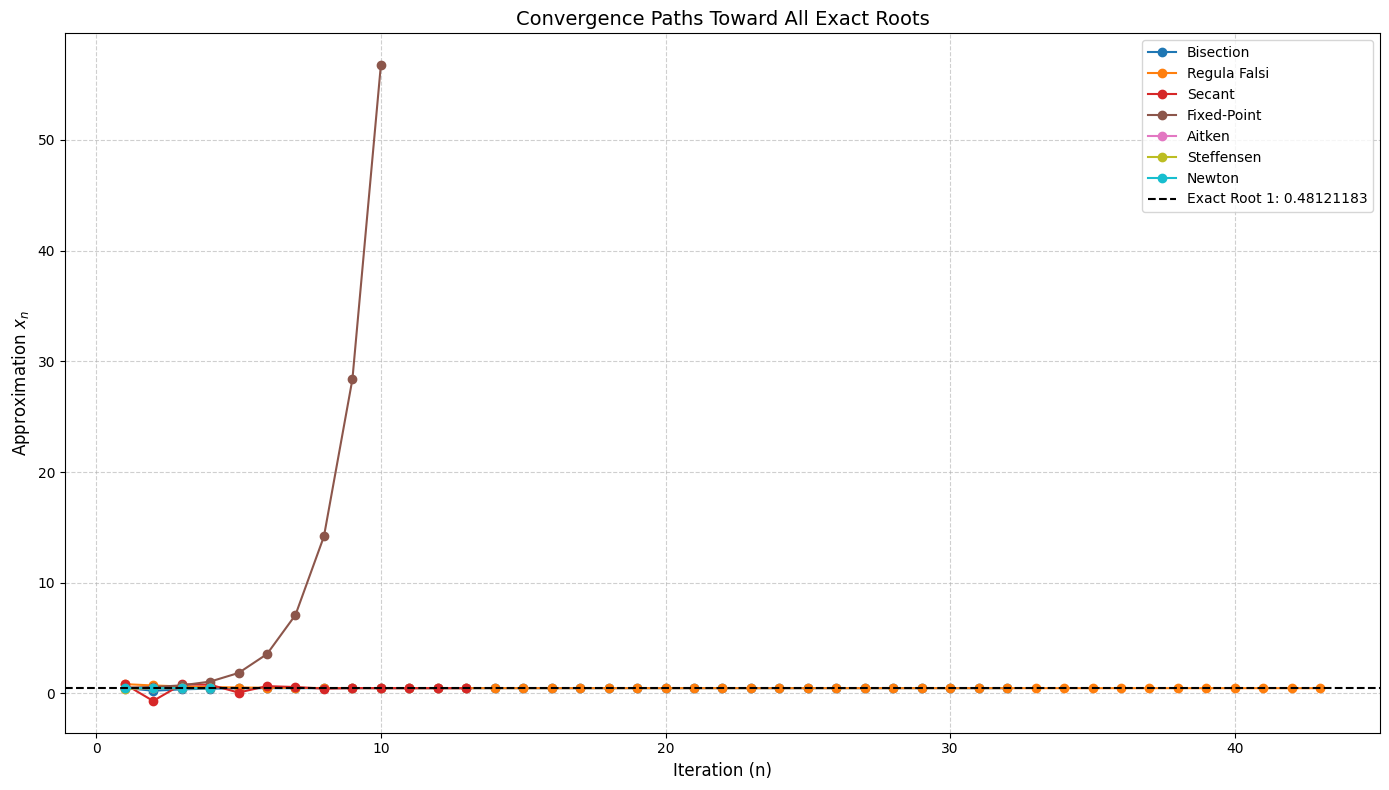

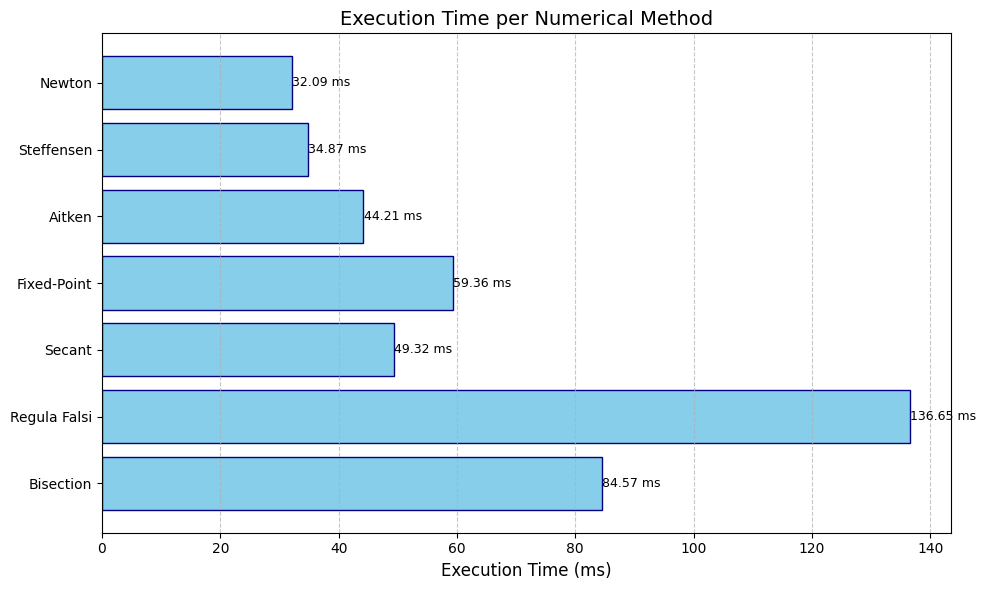


📁 All results (CSV + graphs) saved in folder: 'numerical_results'


In [4]:
def main():
    function = "exp(-x) - exp(-2*x) - exp(-3*x)"
    g_func = "-ln(exp(-2*x) + exp(-3*x))"
    g_func_1 = g_func
    max_iter = 100
    tol = 1e-10
    low, up = 0, 1
    lower_bound, upper_bound = -2, 2

    print("=== NUMERICAL METHODS COMPARISON ===")
    print(f"Function: f(x) = {function}")
    print(f"g(x) for fixed-point: {g_func}")
    print(f"Tolerance: {tol}")
    print(f"Root search interval: [{lower_bound}, {upper_bound}]")
    print()

    import time

    # Run all methods with timing
    results = {}
    exec_times = {}

    methods_config = {
        'Bisection': {'method': 'bisection', 'low': low, 'up': up},
        'Regula Falsi': {'method': 'regula_falsi', 'low': low, 'up': up},
        'Secant': {'method': 'secant', 'low': low, 'up': up},
        'Fixed-Point': {'method': 'fixed_point', 'initial_guess': 0.5, 'g_function': g_func_1},
        'Aitken': {'method': 'aitken', 'initial_guess': 0, 'g_function': g_func},
        'Steffensen': {'method': 'steffensen', 'initial_guess': up, 'g_function': g_func_1},
        'Newton': {'method': 'newton', 'initial_guess': (low + up) / 2}
    }

    for name, config in methods_config.items():
        start = time.perf_counter()
        res = numeric(function, tol=tol, max_iter=max_iter, **config)
        end = time.perf_counter()
        results[name] = res
        exec_times[name] = (end - start) * 1000

    # Display final results
    print("="*80)
    print("FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD")
    print("="*80)
    for index, (name, res) in enumerate(results.items(), 1):
        print(f"\n {index}. Method {name}")
        if res['error']:
            print(f"   Error: {res['error']}")
        elif res['root'] is not None:
            iterations = res['converged_at'] if res['converged_at'] is not None else max_iter
            status = "✓ Converged" if res['converged_at'] is not None else "⚠ Max iterations"
            print(f"   Root: {res['root']:.15f}")
            print(f"   Status: {status} at iteration {iterations}")
        else:
            print("   Failed")

    # ==============================================================================
    # EXACT SOLUTIONS: FIND ALL ROOTS IN [lower_bound, upper_bound]
    # ==============================================================================
    try:
        all_exact_roots = find_all_roots(function, x_range=(-3, 3), steps=2000)
        print(f"\nFound {len(all_exact_roots)} real roots globally:")
        for i, r in enumerate(all_exact_roots, 1):
            print(f"  Root {i}: {r:.15f}")

        exact_roots_in_interval = [r for r in all_exact_roots if lower_bound <= r <= upper_bound]
        print(f"\nRoots in interval [{lower_bound}, {upper_bound}]: {len(exact_roots_in_interval)} found")
        for i, r in enumerate(exact_roots_in_interval, 1):
            print(f"  → Root {i}: {r:.15f}")

    except Exception as e:
        print(f"\nFailed to compute exact solutions: {e}")
        exact_roots_in_interval = []

    # ==============================================================================
    # HELPER: FIND CLOSEST EXACT ROOT
    # ==============================================================================
    def find_closest_root(numeric_root, exact_list):
        if not exact_list:
            return None, None
        closest = min(exact_list, key=lambda r: abs(r - numeric_root))
        return closest, abs(numeric_root - closest)

    # ==============================================================================
    # SUMMARY TABLE
    # ==============================================================================
    print("\n" + "="*130)
    print("COMPARISON SUMMARY")
    print("="*130)
    summary_data = []
    for name, res in results.items():
        if res['error'] or res['root'] is None:
            summary_data.append({
                'Method': name,
                'Numeric Root': 'Error',
                'Closest Root': '—',
                'Iterations': '—',
                'Difference': '—',
                'Status': '—'
            })
        else:
            numeric_root = res['root']
            iterations = res['converged_at'] if res['converged_at'] is not None else f"{max_iter} (max)"
            closest_root, difference = find_closest_root(numeric_root, exact_roots_in_interval)

            status = "Valid" if lower_bound <= numeric_root <= upper_bound else "Invalid"

            summary_data.append({
                'Method': name,
                'Numeric Root': f"{numeric_root:.12f}",
                'Closest Root': f"{closest_root:.12f}" if closest_root is not None else "—",
                'Iterations': iterations,
                'Difference': f"{difference:.15f}" if difference is not None else "—",
                'Status': status
            })

    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))

    # ==============================================================================
    # SAVE ITERATION DATA TO CSV
    # ==============================================================================
    import os
    output_dir = "numerical_results"
    os.makedirs(output_dir, exist_ok=True)

    for name, res in results.items():
        if not res['error'] and not res['iterations'].empty:
            safe_name = "".join(c if c.isalnum() else "_" for c in name)
            filename = os.path.join(output_dir, f"iterations_{safe_name}_EXPONENTIAL.csv")
            res['iterations'].to_csv(filename, index=False, float_format="%.12f")

    summary_file = os.path.join(output_dir, "comparison_summary_EXPONENTIAL.csv")
    df_summary.to_csv(summary_file, index=False)

    # ==============================================================================
    # DISPLAY COMPLETE ITERATION DATA FOR EACH METHOD
    # ==============================================================================
    print("\n" + "="*100)
    print("COMPLETE ITERATION DATA FOR EACH METHOD")
    print("="*100)
    for name, res in results.items():
        print(f"\nITERATIONS FOR METHOD: {name}")
        print("-" * 60)
        if res['error']:
            print(f"No iteration data: {res['error']}")
        elif res['iterations'].empty:
            print("No iteration data (empty DataFrame)")
        else:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(res['iterations'].to_string(index=False, float_format="%.10f"))
        print()

    # ==============================================================================
    # EARLY EXIT IF NO EXACT ROOTS IN INTERVAL
    # ==============================================================================
    if not exact_roots_in_interval:
        print(f"\n⚠️  No exact roots in interval [{lower_bound}, {upper_bound}] → Skipping graphs.")
        print(f"📁 All results (CSV) saved in folder: '{output_dir}'")
        return

    # ==============================================================================
    # GRAPH 1: ABSOLUTE ERROR (LOG SCALE) — CONVERGENCE SPEED
    # ==============================================================================
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            approximations = df['x_n'].values
            if res['converged_at'] is None:
                approximations = np.append(approximations, res['root'])
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        errors = []
        for x in approximations:
            _, diff = find_closest_root(x, exact_roots_in_interval)
            errors.append(diff if diff is not None else float('nan'))
        errors = np.array(errors)
        iterations = np.arange(1, len(errors) + 1)

        valid = np.isfinite(errors)
        if np.any(valid):
            plt.plot(iterations[valid], errors[valid], marker='o', label=name, color=colors[idx])

    plt.yscale('log')
    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Absolute Error |x_n - Closest Root|', fontsize=12)
    plt.title('Convergence Speed Comparison of Numerical Methods', fontsize=14)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_error_EXPONENTIAL.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 2: APPROXIMATION PATH vs ITERATION — WITH ALL EXACT ROOTS
    # ==============================================================================
    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            x_vals = df['x_n'].values.tolist()
            if res['converged_at'] is None:
                x_vals.append(res['root'])
            approximations = np.array(x_vals)
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        iterations = np.arange(1, len(approximations) + 1)
        plt.plot(iterations, approximations, marker='o', label=name, color=colors[idx])

    for i, root in enumerate(exact_roots_in_interval, 1):
        plt.axhline(y=root, color='black', linestyle='--', linewidth=1.5,
                    label=f'Exact Root {i}: {root:.8f}')

    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Approximation $x_n$', fontsize=12)
    plt.title('Convergence Paths Toward All Exact Roots', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_path_EXPONENTIAL.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 3: EXECUTION TIME COMPARISON (HORIZONTAL BAR CHART)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    methods = list(exec_times.keys())
    times = [exec_times[m] for m in methods]

    # Horizontal bar: use `barh` instead of `bar`
    bars = plt.barh(methods, times, color='skyblue', edgecolor='navy')
    plt.xlabel('Execution Time (ms)', fontsize=12)
    plt.title('Execution Time per Numerical Method', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # Add value labels on bars
    for bar, t in zip(bars, times):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{t:.2f} ms', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "execution_time_EXPONENTIAL.png"), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📁 All results (CSV + graphs) saved in folder: '{output_dir}'")


if __name__ == "__main__":
    main()

# **MIXED**

=== NUMERICAL METHODS COMPARISON ===
Function: f(x) = (cos(exp((1/2)*x)))**3 - x**3
g(x) for fixed-point: cos(exp((1/2)*x))
Tolerance: 1e-10
Root search interval: [-1, 1]

FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD

 1. Method Bisection
   Root: 0.363177127670497
   Status: ✓ Converged at iteration 31

 2. Method Regula Falsi
   Root: 0.363177127511742
   Status: ✓ Converged at iteration 44

 3. Method Secant
   Root: 0.363177127637025
   Status: ✓ Converged at iteration 8

 4. Method Fixed-Point
   Root: 0.363177127690668
   Status: ✓ Converged at iteration 40

 5. Method Aitken
   Root: 0.363177127637037
   Status: ✓ Converged at iteration 4

 6. Method Steffensen
   Root: 0.363177127637037
   Status: ✓ Converged at iteration 4

 7. Method Newton
   Root: 0.363177127637037
   Status: ✓ Converged at iteration 5

Found 1 real roots globally:
  Root 1: 0.363177127637037

Roots in interval [-1, 1]: 1 found
  → Root 1: 0.363177127637037

COMPARISON SUMMARY
      Method   Numeric Root 

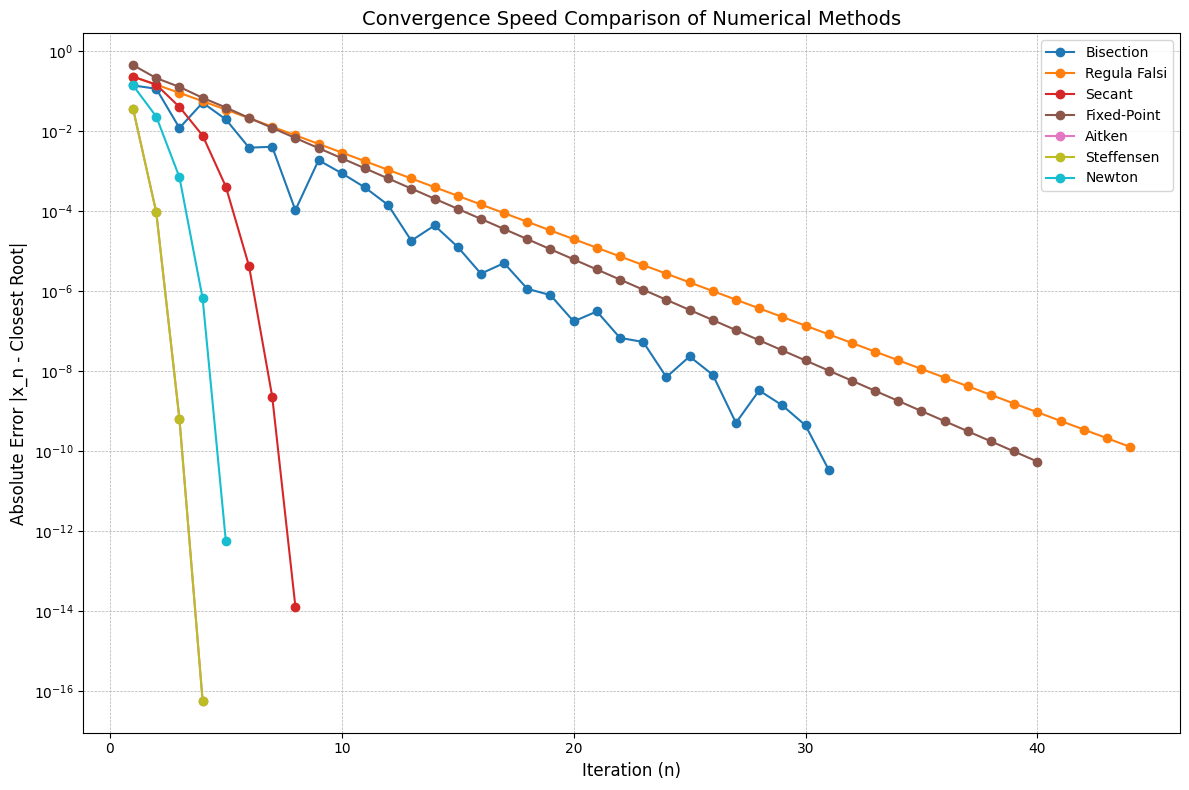

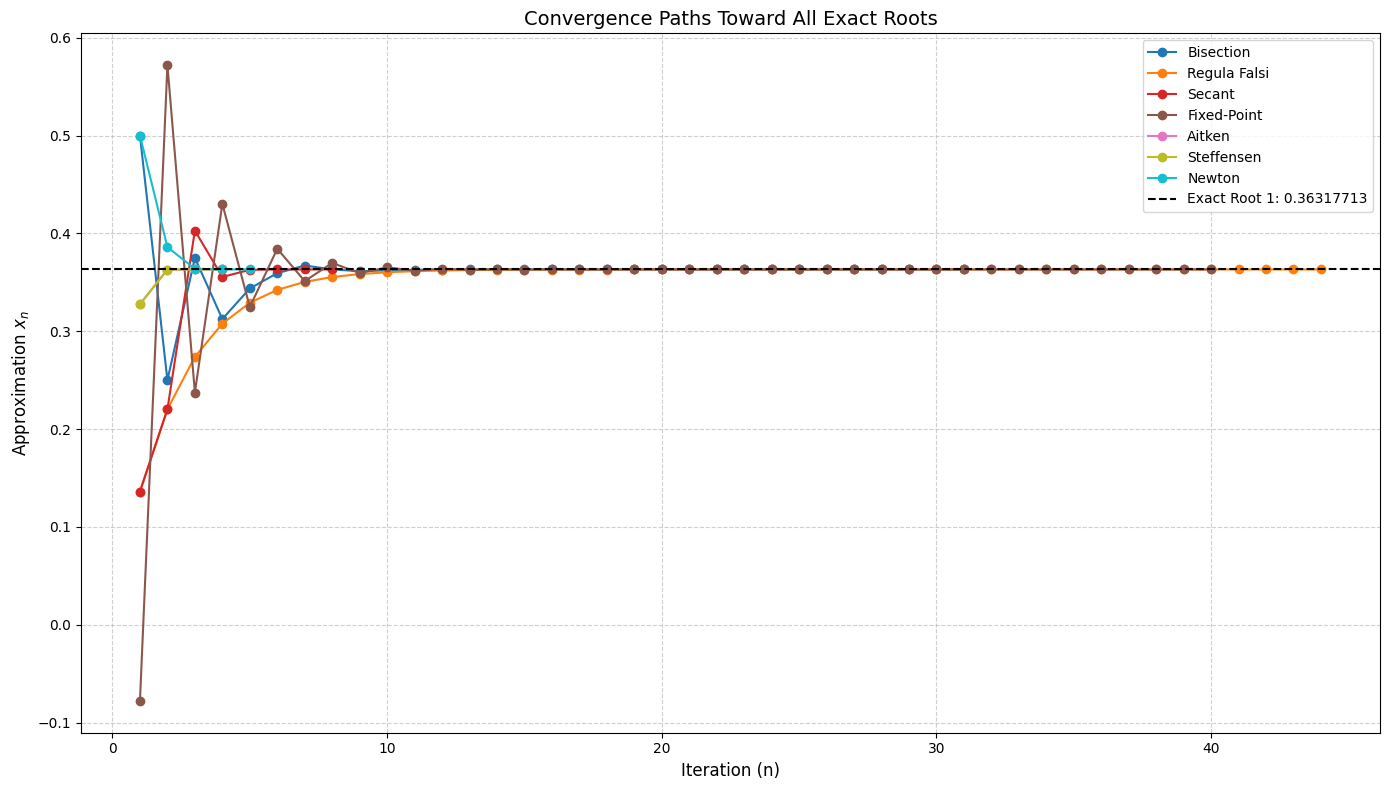

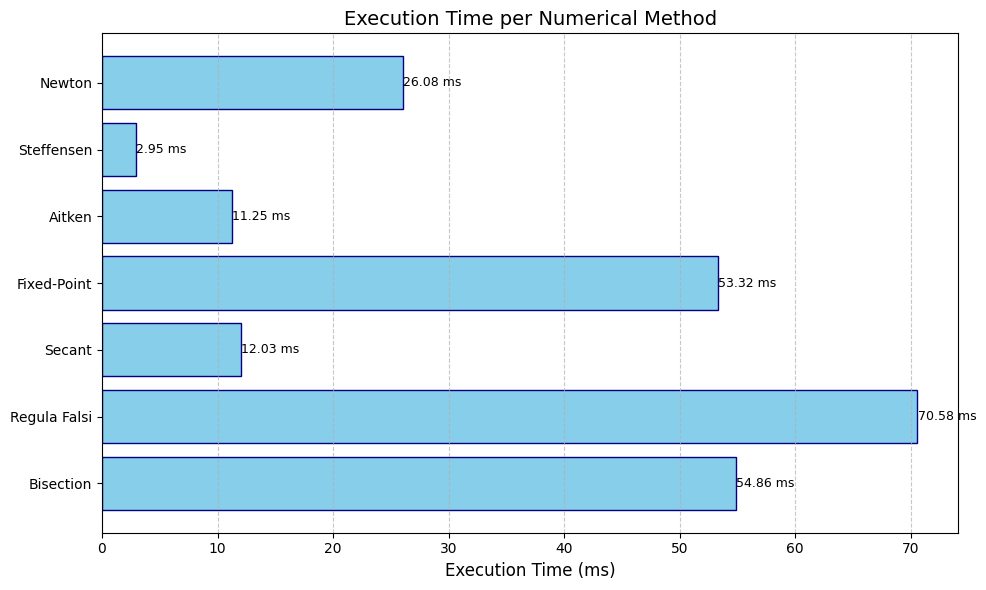


📁 All results (CSV + graphs) saved in folder: 'numerical_results'


In [5]:
def main():
    function = "(cos(exp((1/2)*x)))**3 - x**3"
    g_func = "cos(exp((1/2)*x))"
    g_func_1 = g_func
    max_iter = 100
    tol = 1e-10
    low, up = 0, 1
    lower_bound, upper_bound = -1, 1

    print("=== NUMERICAL METHODS COMPARISON ===")
    print(f"Function: f(x) = {function}")
    print(f"g(x) for fixed-point: {g_func}")
    print(f"Tolerance: {tol}")
    print(f"Root search interval: [{lower_bound}, {upper_bound}]")
    print()

    import time

    # Run all methods with timing
    results = {}
    exec_times = {}

    methods_config = {
        'Bisection': {'method': 'bisection', 'low': low, 'up': up},
        'Regula Falsi': {'method': 'regula_falsi', 'low': low, 'up': up},
        'Secant': {'method': 'secant', 'low': low, 'up': up},
        'Fixed-Point': {'method': 'fixed_point', 'initial_guess': up, 'g_function': g_func_1},
        'Aitken': {'method': 'aitken', 'initial_guess': up, 'g_function': g_func},
        'Steffensen': {'method': 'steffensen', 'initial_guess': up, 'g_function': g_func_1},
        'Newton': {'method': 'newton', 'initial_guess': (low + up) / 2}
    }

    for name, config in methods_config.items():
        start = time.perf_counter()
        res = numeric(function, tol=tol, max_iter=max_iter, **config)
        end = time.perf_counter()
        results[name] = res
        exec_times[name] = (end - start) * 1000

    # Display final results
    print("="*80)
    print("FINAL RESULTS AFTER CONVERGENCE OF EACH METHOD")
    print("="*80)
    for index, (name, res) in enumerate(results.items(), 1):
        print(f"\n {index}. Method {name}")
        if res['error']:
            print(f"   Error: {res['error']}")
        elif res['root'] is not None:
            iterations = res['converged_at'] if res['converged_at'] is not None else max_iter
            status = "✓ Converged" if res['converged_at'] is not None else "⚠ Max iterations"
            print(f"   Root: {res['root']:.15f}")
            print(f"   Status: {status} at iteration {iterations}")
        else:
            print("   Failed")

    # ==============================================================================
    # EXACT SOLUTIONS: FIND ALL ROOTS IN [lower_bound, upper_bound]
    # ==============================================================================
    try:
        all_exact_roots = find_all_roots(function, x_range=(-3, 3), steps=2000)
        print(f"\nFound {len(all_exact_roots)} real roots globally:")
        for i, r in enumerate(all_exact_roots, 1):
            print(f"  Root {i}: {r:.15f}")

        exact_roots_in_interval = [r for r in all_exact_roots if lower_bound <= r <= upper_bound]
        print(f"\nRoots in interval [{lower_bound}, {upper_bound}]: {len(exact_roots_in_interval)} found")
        for i, r in enumerate(exact_roots_in_interval, 1):
            print(f"  → Root {i}: {r:.15f}")

    except Exception as e:
        print(f"\nFailed to compute exact solutions: {e}")
        exact_roots_in_interval = []

    # ==============================================================================
    # HELPER: FIND CLOSEST EXACT ROOT
    # ==============================================================================
    def find_closest_root(numeric_root, exact_list):
        if not exact_list:
            return None, None
        closest = min(exact_list, key=lambda r: abs(r - numeric_root))
        return closest, abs(numeric_root - closest)

    # ==============================================================================
    # SUMMARY TABLE
    # ==============================================================================
    print("\n" + "="*130)
    print("COMPARISON SUMMARY")
    print("="*130)
    summary_data = []
    for name, res in results.items():
        if res['error'] or res['root'] is None:
            summary_data.append({
                'Method': name,
                'Numeric Root': 'Error',
                'Closest Root': '—',
                'Iterations': '—',
                'Difference': '—',
                'Status': '—'
            })
        else:
            numeric_root = res['root']
            iterations = res['converged_at'] if res['converged_at'] is not None else f"{max_iter} (max)"
            closest_root, difference = find_closest_root(numeric_root, exact_roots_in_interval)

            status = "Valid" if lower_bound <= numeric_root <= upper_bound else "Invalid"

            summary_data.append({
                'Method': name,
                'Numeric Root': f"{numeric_root:.12f}",
                'Closest Root': f"{closest_root:.12f}" if closest_root is not None else "—",
                'Iterations': iterations,
                'Difference': f"{difference:.15f}" if difference is not None else "—",
                'Status': status
            })

    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))

    # ==============================================================================
    # SAVE ITERATION DATA TO CSV
    # ==============================================================================
    import os
    output_dir = "numerical_results"
    os.makedirs(output_dir, exist_ok=True)

    for name, res in results.items():
        if not res['error'] and not res['iterations'].empty:
            safe_name = "".join(c if c.isalnum() else "_" for c in name)
            filename = os.path.join(output_dir, f"iterations_{safe_name}_MIXED.csv")
            res['iterations'].to_csv(filename, index=False, float_format="%.12f")

    summary_file = os.path.join(output_dir, "comparison_summary_MIXED.csv")
    df_summary.to_csv(summary_file, index=False)

    # ==============================================================================
    # DISPLAY COMPLETE ITERATION DATA FOR EACH METHOD
    # ==============================================================================
    print("\n" + "="*100)
    print("COMPLETE ITERATION DATA FOR EACH METHOD")
    print("="*100)
    for name, res in results.items():
        print(f"\nITERATIONS FOR METHOD: {name}")
        print("-" * 60)
        if res['error']:
            print(f"No iteration  {res['error']}")
        elif res['iterations'].empty:
            print("No iteration data (empty DataFrame)")
        else:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(res['iterations'].to_string(index=False, float_format="%.10f"))
        print()

    # ==============================================================================
    # EARLY EXIT IF NO EXACT ROOTS IN INTERVAL
    # ==============================================================================
    if not exact_roots_in_interval:
        print(f"\n⚠️  No exact roots in interval [{lower_bound}, {upper_bound}] → Skipping graphs.")
        print(f"📁 All results (CSV) saved in folder: '{output_dir}'")
        return

    # ==============================================================================
    # GRAPH 1: ABSOLUTE ERROR (LOG SCALE) — CONVERGENCE SPEED
    # ==============================================================================
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            approximations = df['x_n'].values
            if res['converged_at'] is None:
                approximations = np.append(approximations, res['root'])
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        errors = []
        for x in approximations:
            _, diff = find_closest_root(x, exact_roots_in_interval)
            errors.append(diff if diff is not None else float('nan'))
        errors = np.array(errors)
        iterations = np.arange(1, len(errors) + 1)

        valid = np.isfinite(errors)
        if np.any(valid):
            plt.plot(iterations[valid], errors[valid], marker='o', label=name, color=colors[idx])

    plt.yscale('log')
    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Absolute Error |x_n - Closest Root|', fontsize=12)
    plt.title('Convergence Speed Comparison of Numerical Methods', fontsize=14)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_error_MIXED.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 2: APPROXIMATION PATH vs ITERATION — WITH ALL EXACT ROOTS
    # ==============================================================================
    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    for idx, (name, res) in enumerate(results.items()):
        if res['error'] or res['iterations'].empty:
            continue

        df = res['iterations'].copy()
        method_key = name.lower()

        if 'bisection' in method_key or 'regula' in method_key:
            approximations = df['c'].values
        elif 'secant' in method_key:
            approximations = df['x2'].values
        elif 'fixed' in method_key:
            approximations = df['x_next'].values
        elif 'newton' in method_key:
            x_vals = df['x_n'].values.tolist()
            if res['converged_at'] is None:
                x_vals.append(res['root'])
            approximations = np.array(x_vals)
        elif 'aitken' in method_key:
            approximations = df['x_hat'].values
        elif 'steffensen' in method_key:
            approximations = df['x_next'].values
        else:
            continue

        iterations = np.arange(1, len(approximations) + 1)
        plt.plot(iterations, approximations, marker='o', label=name, color=colors[idx])

    for i, root in enumerate(exact_roots_in_interval, 1):
        plt.axhline(y=root, color='black', linestyle='--', linewidth=1.5,
                    label=f'Exact Root {i}: {root:.8f}')

    plt.xlabel('Iteration (n)', fontsize=12)
    plt.ylabel('Approximation $x_n$', fontsize=12)
    plt.title('Convergence Paths Toward All Exact Roots', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "convergence_path_MIXED.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # GRAPH 3: EXECUTION TIME COMPARISON (HORIZONTAL BAR CHART)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    methods = list(exec_times.keys())
    times = [exec_times[m] for m in methods]

    # Horizontal bar: use `barh` instead of `bar`
    bars = plt.barh(methods, times, color='skyblue', edgecolor='navy')
    plt.xlabel('Execution Time (ms)', fontsize=12)
    plt.title('Execution Time per Numerical Method', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # Add value labels on bars
    for bar, t in zip(bars, times):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{t:.2f} ms', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "execution_time_MIXED.png"), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📁 All results (CSV + graphs) saved in folder: '{output_dir}'")


if __name__ == "__main__":
    main()